# Projet Kit big data

In [2190]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
import re
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import datetime
import openpyxl
from pandas.tseries.offsets import Day, Hour
from pytz import timezone
import locale
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import colorlover as cl
init_notebook_mode(connected=True)
import plotly.express as px
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# I. Acquisition des données

## Fichiers excel avec les classements

In [172]:
#On définit le dossier classement comme répertoire par défaut
os.chdir(r'C:\Users\benja\OneDrive\Documents\Telecom\Kit-data-science\Projet final\Classements')

In [173]:
#On reconstruit les url des fichiers excel après inspection de la page web
def get_excel_url (pattern, datelist, hourlist):
    url = []
    for date in datelist:
        for hour in hourlist:
            url.append(pattern + date.strftime("%Y%m%d") + "_" +  hour + date.strftime("%M%S") + ".xlsx")
    #On commence le premier jr à 14h et on termine le dernier jr à 8h
    return url[3:-4]

In [174]:
#Requete http + sauvegarde des fichiers
def save_excel_url (url_list):
    for url in url_list:
        r = requests.get(url)

        #create a new file with xlsx extension
        save_file= open(url.split('/')[-1], 'wb')

        #save file with content received from r
        save_file.write(r.content)

        #close file
        save_file.close()

In [175]:
datelist = pd.date_range(start = "2020-11-08", end = "2021-03-05", freq = 'D').tolist()
hourlist = ['04', '08', '11', '14', '17', '21']

url_list = get_excel_url('https://www.vendeeglobe.org/download-race-data/vendeeglobe_', datelist, hourlist)

In [176]:
#Requête http pour chaque url et sauvegarde du fichier excel
save_excel_url (url_list)

## Fiches techniques des voiliers 

In [177]:
#Web scraping de la page web spécifique aux specs des bateaux
response = requests.get("https://www.vendeeglobe.org/fr/glossaire")
soup = BeautifulSoup(response.content)

In [178]:
def get_sails_specs():
    sails = {}
    specs = {}
    for div_tag in soup.find_all('div', attrs = {"class" : "boats-list__popup-infos"}):
        specs = {}
        h3_tag = div_tag.find('h3', attrs = {'class' : "boats-list__popup-title"})
        ul_tag = h3_tag.find_next()
        for li_tag in ul_tag.find_all('li'):
            tmp = li_tag.text.split(':')
            specs[tmp[0].strip()] = tmp[1].strip()
        sails[h3_tag.text] = specs
    return sails

In [2043]:
sails_spec = get_sails_specs()
sails_spec = pd.DataFrame(sails_spec).T

# I.II Chargement des données

## Réparation des fichiers excel

In [181]:
#Fonction permettant de "réparer" le fichiers excel et les rendre lisibles avec pd.read_excel
def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)

In [182]:
def fix_excel_files ():
    for filename in os.listdir():
        if filename.endswith(".xlsx"):
             change_in_zip(filename, name_filter='xl/styles.xml', change=lambda d: re.sub(b'xxid="\d*"', b"", d))

In [183]:
#Reparation des fichiers
fix_excel_files()

## Lecture des fichiers excel et sauvegarde au format .pkl

In [287]:
#On prépare le renommage des colonnes pour plus de simplicité/rapidité lors de l'analyse
name_list = []
name_list.extend(["Rang", "Nat./Voile", "Skipper/Bateau", 
                  "Heure FR", "Lat", "Long", "Cap_30", "Vit_30", "VMG_30", "Dist_30", 
                  "Cap_last", "Vit_last", "VMG_last", "Dist_last", "Cap_24", "Vit_24", 
                  "VMG_24", "Dist_24", "DTF", "DTL"])

In [288]:
def excel_to_pkl():
    for filename in os.listdir():
        if filename.endswith(".xlsx"):
            df = pd.read_excel(filename, header = 4, index_col = 0, names = name_list, skipfooter = 4)
            df.to_pickle("df_" + re.search('[0-9]{8}_[0-9]{6}', filename)[0] + ".pkl")
        else:
            continue

In [289]:
def load_data (date_index):
    df_list, count_date = [], 0
    for filename in os.listdir():
        if filename.endswith(".pkl"):
            df = pd.read_pickle("df_" + re.search('[0-9]{8}_[0-9]{6}', filename)[0] + ".pkl")
            df.insert(0, "date", date_index[count_date])
            df_list.append(df)
            count_date += 1
    return (df_list)

In [293]:
#Format excel au format pkl
excel_to_pkl()

In [294]:
#Préparation du datetime index
d1 = pd.date_range("2020-11-08 04:00:00", "2021-03-05 08:00:00", freq="D")

In [295]:
date_index = d1.union(d1 + Hour(4)).union(d1 + Hour(7)).union(d1 + Hour(10)).union(d1 + Hour(13)).union(d1 + Hour(17))[3:-4]

In [297]:
#Chargement des fichiers
df_list = load_data(date_index)

# II. Préparation des données

## II.I Données condensant les classements 

In [298]:
#Avant préparation des données on dispose d'une liste de df
df_list[0].head(3)

,date,Rang,Nat./Voile,Skipper/Bateau,Heure FR,Lat,Long,Cap_30,Vit_30,VMG_30,...,Cap_last,Vit_last,VMG_last,Dist_last,Cap_24,Vit_24,VMG_24,Dist_24,DTF,DTL
NaN,2020-11-08 14:00:00,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,...,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
NaN,2020-11-08 14:00:00,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,...,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
NaN,2020-11-08 14:00:00,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,...,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm


In [2044]:
#Concaténation des données
df_class = pd.concat(df_list)

### Vers la fin de la course (27 janv 17h UTC), le format des fichiers excel change avec les arrivées des voiliers : on décide donc de s'arrêter juste avant

In [2045]:
#On tz localise les dates
df_class["date"] = df_class["date"].apply(lambda x: x.tz_localize('UTC'))

In [2046]:
#suppréssion des fichiers postérieurs à la date mentionnée
df_class = df_class.loc[df_class["date"] < "2021-01-27 17:00:00"]

In [2047]:
#Création d'une colonne Nationalité
df_class["Nat"] = df_class["Nat./Voile"].apply(lambda x : re.search('[A-Z]{3}', x)[0])

In [2048]:
#Création d'une colonne Voile
df_class["Voile"] = df_class["Nat./Voile"].apply(lambda x : int(re.findall('[0-9]+', x)[0]))

In [2049]:
#Suppression Nat./Voile
df_class = df_class.drop(columns = "Nat./Voile")

In [2050]:
#Création des colonnes distinctes Skipper & Bateau
df_class["Skipper"] = df_class["Skipper/Bateau"].apply(lambda x : x.split('\n')[0])
df_class["Bateau"] = df_class["Skipper/Bateau"].apply(lambda x : x.split('\n')[1])

In [2051]:
#Suppression Skipper/Bateau
df_class = df_class.drop(columns = "Skipper/Bateau")

In [2052]:
#Homogénéisation des noms des bateaux
df_class["Bateau"] = df_class["Bateau"].apply(lambda x : x.title())

In [2053]:
df0 = df_class.copy()

In [2054]:
#On décide de retirer les observations avec des col contenant des valeurs manquantes, correspondant aux skipper "NL" et "RET"
df_class = df_class.loc[df_class.isnull().any(axis = 1) == False]

In [2055]:
#Suppression de la colonne Heure FR qui est redondante
df_class = df_class.drop(columns = "Heure FR")

In [2056]:
#Changement de fuseau horaire UTC --> FR
tz = timezone("Europe/Paris")
df_class["date"] = df_class["date"].apply(lambda x : x.astimezone(tz))

### Conversion des Lat et Long en deg, mn, sec en decimales

In [2057]:
def dms2dec(deg, mn, sec, hemi) :
    if hemi == 'W' or hemi == "S":
        res = -(deg + (mn/60) + (sec/3600))
    else:
        res = deg + (mn/60) + (sec/3600)
    return res

In [2058]:
lat = df_class["Lat"].apply(lambda x : re.findall('[0-9A-Z]+', x))
long = df_class["Long"].apply(lambda x : re.findall('[0-9A-Z]+', x))

In [2059]:
df_class["Lat"] = lat.apply(lambda x : dms2dec(float(x[0]), float(x[1]), float(x[2]), x[3]))
df_class["Long"] = long.apply(lambda x : dms2dec(float(x[0]), float(x[1]), float(x[2]), x[3]))

In [2060]:
#On recupere uniquement les nombres sans les unites
df_class[["Cap_30", "Cap_last", "Cap_24", "Vit_30", "Vit_last", "Vit_24", "VMG_30", "VMG_last", "VMG_24", "Dist_30", "Dist_last", "Dist_24", "DTF", "DTL"]] = df_class[["Cap_30", "Cap_last", "Cap_24", "Vit_30", "Vit_last", "Vit_24", "VMG_30", "VMG_last", "VMG_24", "Dist_30", "Dist_last", "Dist_24", "DTF", "DTL"]].applymap(lambda x : re.findall('[0-9.]+', x)[0])

In [2061]:
col = df_class.columns.to_list()
col.remove("Nat")
col.remove("Skipper")
col.remove("Bateau")
col.remove("date")

#On convertit les valeurs des col numériques au bon format
df_class[col] = df_class[col].apply(lambda x : pd.to_numeric(x, errors = "raise"))

In [2062]:
df_class = df_class.reset_index(drop = True)

In [2063]:
df_class.head(5)

,date,Rang,Lat,Long,Cap_30,Vit_30,VMG_30,Dist_30,Cap_last,Vit_last,...,Cap_24,Vit_24,VMG_24,Dist_24,DTF,DTL,Nat,Voile,Skipper,Bateau
0,2020-11-08 15:00:00+01:00,1,46.412778,-1.846667,241,17.7,17.5,0.3,357,0.0,...,201,0.3,0.3,6.1,24293.9,0.0,FRA,18,Louis Burton,Bureau Vallée 2
1,2020-11-08 15:00:00+01:00,2,46.409444,-1.839444,241,11.1,10.9,0.4,357,0.0,...,196,0.3,0.2,6.0,24294.2,0.4,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco
2,2020-11-08 15:00:00+01:00,3,46.425278,-1.844167,244,15.5,15.5,0.5,357,0.0,...,199,0.2,0.2,5.5,24294.3,0.5,FRA,8,Jérémie Beyou,Charal
3,2020-11-08 15:00:00+01:00,4,46.419722,-1.835556,244,13.2,13.1,0.7,357,0.0,...,196,0.2,0.2,5.6,24294.5,0.6,FRA,59,Thomas Ruyant,Linkedout
4,2020-11-08 15:00:00+01:00,5,46.416389,-1.832222,246,10.9,10.9,0.2,357,0.0,...,195,0.8,0.7,5.8,24294.5,0.6,FRA,53,Maxime Sorel,V And B Mayenne


## II.II Fiches techniques des voiliers

In [2064]:
sails_spec0 = sails_spec.copy()

In [2065]:
# On cherche tous les lignes avec au moins un NaN
sails_spec.loc[sails_spec.isnull().any(axis = 1)]

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
APIVIA,FRA 79,NaN,Verdier,CDK technologies - MerConcept,05 Août 2019,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier,350 m2,560 m2
PRB,FRA 85,NaN,Verdier - VPLP,CDK Technologies,08 Mars 2010,"18,28 m","5,50 m","4,50 m",NC,foils,"27,40 m",Acier mécano soudé,300 m2,600 m2
LinkedOut,NaN,NaN,Verdier,Persico,03 Septembre 2019,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier forgé,350 m2,560 m2
DMG MORI Global One,JPN 11,NaN,VPLP,Multiplast,05 Septembre 2019,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier forgé,320 m2,580 m2
ARKEA PAPREC,4,NaN,Juan Kouyoumdjian,CDK Technologies / Assemblage,19 Juillet 2019,"18,28 m","5,70 m","4,50 m",8 t,foiler,29 m,Inox usiné,260 m2,600 m2
HUGO BOSS,GBR 99,NaN,VPLP - Alex Thomson Racing (led by Pete Hobson),Carrington Boats,15 Août 2019,"18,28 m","5,40 m","4,50 m","7,7 t",foils,29 m,acier forgé,330 m2,630 m2
L'OCCITANE EN PROVENCE,2,NaN,Samuel Manuard,Black Pepper©,31 Janvier 2020,"18,28 m","5,50 m","4,50 m","7,8 t",foils,28 m,acier forgé,270 m2,535 m2
CORUM L'EPARGNE,FRA 6,NaN,Juan Kouyoumdjian,CDK technologies - Mer Agitée,15 Mai 2020,"18,28 m","5,70 m","4,50 m","7,9 t",foils,"27,30 m",NaN,270 m2,535 m2


In [2066]:
#On supprime la colonne "Anciens noms du bateau", "Architecte" et "Chantier" qui n'ont pas d'intérêt statistique
sails_spec = sails_spec.drop(columns = "Anciens noms du bateau")
sails_spec = sails_spec.drop(columns = "Architecte")
sails_spec = sails_spec.drop(columns = "Chantier")

In [2067]:
#On définit à la main le n° de voile de LinkedOut
sails_spec.loc["LinkedOut", "Numéro de voile"] = "FRA 59"

In [2068]:
#Conversion des dates de lancement
locale.setlocale(locale.LC_ALL, 'fr') # french
sails_spec["Date de lancement"] = pd.to_datetime(sails_spec["Date de lancement"], format = "%d %B %Y")

In [2069]:
#Création d'une va "Foils" indiquant si le voilier dispose de foils
sails_spec["Foils"] = sails_spec["Nombre de dérives"].apply(lambda x : 1 if 'foil' in x else 0)
sails_spec = sails_spec.drop(columns = "Nombre de dérives")

### On transforme la v.a  catégorielle "Voile quille" afin de pouvoir l'exploiter plus tard dans nos analyses

In [2070]:
sails_spec["Voile quille"].str.title().value_counts()

Acier Forgé                         12
Acier                               10
Carbone                              3
Monotype                             2
Acier Mécano Soudé                   2
Basculante Avec Vérin                1
Basculante Sur Vérin Hydraulique     1
Inox Usiné                           1
Name: Voile quille, dtype: int64

### On distingue 4 grandes catégories : 
* 1 : Acier
* 2 : Carbone
* 3 : Basculante sur/avec Vérin
* 4 : Monotype

In [2071]:
mapping = {'Acier Forgé' : 'Acier', 'Acier Mécano Soudé' : 'Acier', 'Inox Usiné' : 'Acier',
           'Basculante Sur Vérin Hydraulique' : 'Basculante Sur Vérin', 'Basculante Avec Vérin' : 'Basculante Sur Vérin'}
sails_spec["Voile quille"] = sails_spec["Voile quille"].str.title().apply(lambda x : mapping.get(x, x))

In [2072]:
#On impute la valeur manquante dans "Voile quille" pour "CORUM L'EPARGNE" par la valeur majoritaire çad "Acier"
sails_spec.loc["CORUM L'EPARGNE", "Voile quille"] = "Acier"

In [2073]:
#dummification
tab_voile_quille = pd.get_dummies(sails_spec["Voile quille"])
sails_spec = sails_spec.drop(columns = "Voile quille")

In [2074]:
sails_spec[tab_voile_quille.columns] = tab_voile_quille

In [2075]:
#On transforme la colonne Numéro de Voile en gardant juste le n° qui suffira à réaliser une jointure plus tard
sails_spec["Numéro de voile"] = sails_spec["Numéro de voile"].apply(lambda x : int(re.findall('[0-9]+', x)[0]))

In [2076]:
#Remplacement des ',' par des '.'
sails_spec[["Longueur", "Largeur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât"]] = sails_spec[["Longueur", "Largeur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât"]].applymap(lambda x : x.replace(',', '.'))

In [2077]:
#On extrait uniquement les nombre sans les unités
sails_spec[["Longueur", "Largeur", "Tirant d'eau", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant"]] = sails_spec[["Longueur", "Largeur", "Tirant d'eau", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant"]].applymap(lambda x : re.findall('[0-9.]+', x)[0])

### On observe la présence de certains "NC" dans "déplacement" qu'on suppose équivalent  à NaN

In [2078]:
#On extrait les chiffres sans les unités
sails_spec["Déplacement (poids)"] = sails_spec["Déplacement (poids)"].apply(lambda x : x.split('t')[0].strip())

In [2079]:
#On remplace les "NC" par des NaN
sails_spec["Déplacement (poids)"] = sails_spec["Déplacement (poids)"].replace(['NC', 'nc'], np.nan)

In [2080]:
#On impute les NaN par la médiane de la série
sails_spec.loc[sails_spec["Déplacement (poids)"].isnull(), "Déplacement (poids)"] = sails_spec["Déplacement (poids)"].median()

In [2081]:
col = sails_spec.columns.to_list()
col.remove("Date de lancement")

#On convertit les valeurs des col numériques au bon format
sails_spec[col] = sails_spec[col].apply(lambda x : pd.to_numeric(x, errors = "raise"))

In [2082]:
sails_spec.head(5)

,Numéro de voile,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Foils,Acier,Basculante Sur Vérin,Carbone,Monotype
NEWREST - ART & FENÊTRES,56,2015-08-01,18.28,5.85,4.5,7.0,29.0,320,570,1,0,0,0,1
PURE - Best Western®,49,2007-03-08,18.28,5.80,4.5,9.0,28.0,280,560,0,1,0,0,0
TSE - 4MYPLANET,72,1998-03-01,18.28,5.54,4.5,9.0,29.0,260,580,0,1,0,0,0
Maître CoQ IV,17,2015-03-12,18.28,5.80,4.5,8.0,29.0,310,550,1,1,0,0,0
CHARAL,8,2018-08-18,18.28,5.85,4.5,8.0,29.0,320,600,1,1,0,0,0


## II.III Réunification des données

J'ai remarqué une incohérence entre les données des tableaux excel et les données présentes sur le site du Vendée globe concernant les *numéros de voile*. En effet, pour **Medallia** et **SEAEXPLORER**, on obseverve que les n° de voile sont respectivement **GBR77** et **16** sur le site internet (récupéré par web scraping) tandis que sur les fichiers excel, les numéros sont respectivement **GBR 777** et **10**. Ces éléments causent alors un problème lors du merge des 2 df.
On décide donc de rectifier cette erreur pour rendre possible le merge.

In [2083]:
sails_spec.loc["SEAEXPLORER - YACHT CLUB DE MONACO", "Numéro de voile"] = 10
sails_spec.loc["MEDALLIA", "Numéro de voile"] = 777

In [2111]:
#On fusionne les deux df (classements + specs des bateaux)
df_all = pd.merge(df_class,
              sails_spec,
              left_on='Voile',
              right_on='Numéro de voile',
              how='left')

In [2112]:
df_all.head(5)

,date,Rang,Lat,Long,Cap_30,Vit_30,VMG_30,Dist_30,Cap_last,Vit_last,...,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Foils,Acier,Basculante Sur Vérin,Carbone,Monotype
0,2020-11-08 15:00:00+01:00,1,46.412778,-1.846667,241,17.7,17.5,0.3,357,0.0,...,4.5,7.6,28.0,300,600,1,1,0,0,0
1,2020-11-08 15:00:00+01:00,2,46.409444,-1.839444,241,11.1,10.9,0.4,357,0.0,...,4.5,7.6,29.0,290,490,1,1,0,0,0
2,2020-11-08 15:00:00+01:00,3,46.425278,-1.844167,244,15.5,15.5,0.5,357,0.0,...,4.5,8.0,29.0,320,600,1,1,0,0,0
3,2020-11-08 15:00:00+01:00,4,46.419722,-1.835556,244,13.2,13.1,0.7,357,0.0,...,4.5,8.0,29.0,350,560,1,1,0,0,0
4,2020-11-08 15:00:00+01:00,5,46.416389,-1.832222,246,10.9,10.9,0.2,357,0.0,...,4.5,7.7,29.0,365,700,0,1,0,0,0


# III. Analyses et story telling

## III.I Analyse descriptive

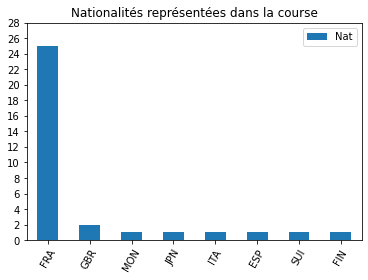

In [2113]:
#A la date "2020-11-08 22:00:00+01:00", tous les skippers sont en course
(df_all.loc[df_all["date"] == "2020-11-08 22:00:00+01:00", "Nat"].value_counts()).plot(kind = 'bar', rot = "60", title = "Nationalités représentées dans la course");
plt.yticks(range(0, 30, 2))
plt.legend();

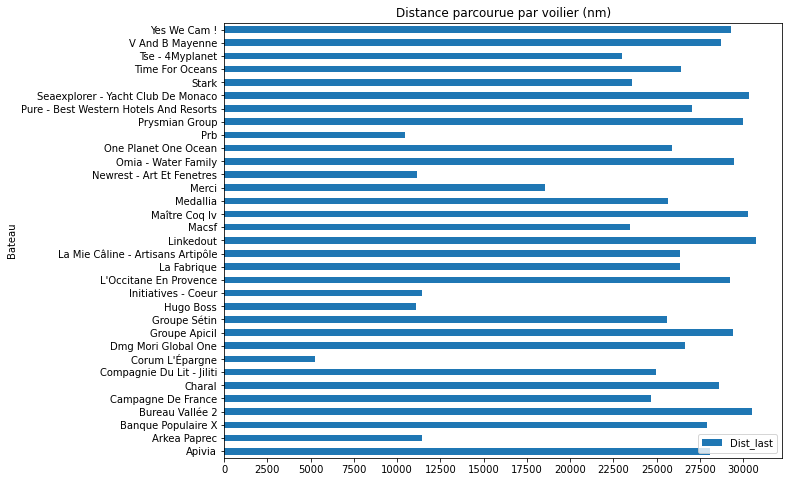

In [2114]:
fig = plt.figure(figsize = (10, 8))
df_all.groupby('Bateau')["Dist_last"].sum().plot(kind = 'barh', title = "Distance parcourue par voilier (nm)");
plt.xticks(range(0, 32000, 2500))
plt.legend();

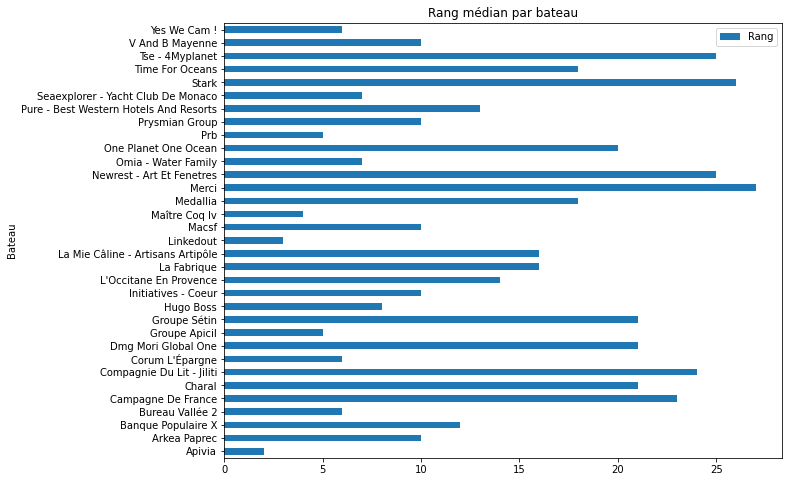

In [2115]:
fig = plt.figure(figsize = (10, 8))
df_all.groupby("Bateau")["Rang"].median().plot(kind = 'barh', title = "Rang médian par bateau");
plt.legend();

In [2116]:
sails_path = df_all.loc[(df_all["Bateau"] == "Yes We Cam !") | (df_all["Bateau"] == "Prb") | (df_all["Bateau"] == "Linkedout")]

In [2117]:
#On rappelle qu'on a choisi de s'arrêter vers la fin de la course ce qui explique que les trajets s'arrête légèrement avant l'arrivée
fig = px.line_geo(sails_path, lat = "Lat", lon = "Long",
                  projection="orthographic", color  = "Bateau", title = "Carte avec les routes de plusieurs voiliers" )
fig.show()

## III.II Analyse statistique

### Corrélation de Pearson entre variables

In [2118]:
#On supprime les lat et long qui ne servent plus + 'Tirant d'eau' et 'Longueur' qui sont constantes (aucun intérêt)
df_all = df_all.drop(columns = ['Tirant d\'eau', 'Longueur', 'Lat', 'Long'])

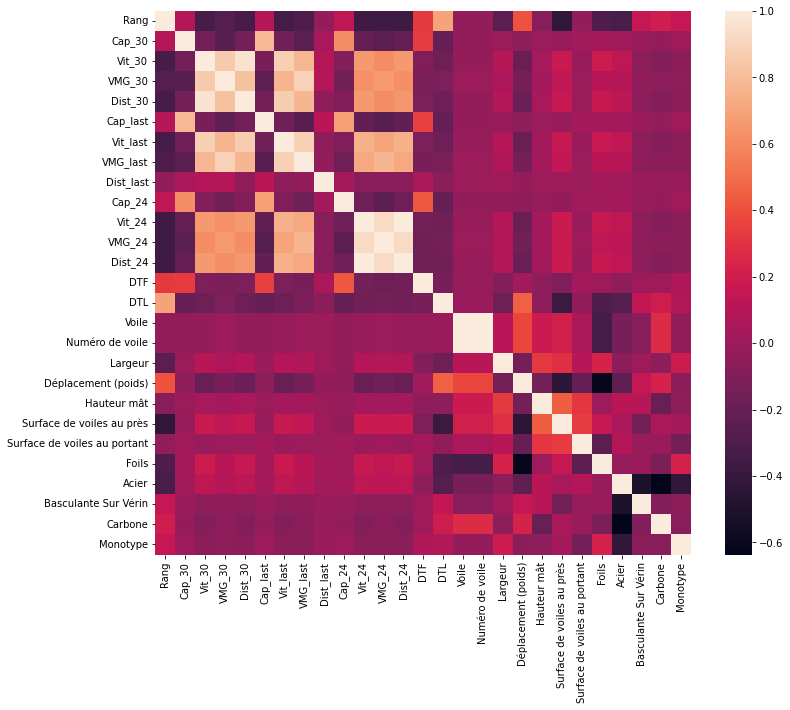

In [2119]:
corr_df = df_all.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=False)
plt.show()

### Interprétation :
On observe une très forte corrélation pour la paire (VMG, Rang) tout comme (Distance, Rang) ainsi que pour (Foils, Rang)

### A. Régression linéaire entre le classement (rang), la vitesse utile (VMG) des voiliers (depuis le dernier classement) et le précédent rang
On cherche ainsi à réaliser une régréssion linéaire de la forme $y_{rang(t)} = \theta_0 + \theta_1 * VMG +  \theta_2 * y_{rang(t-1)}$.
Nous allons ainsi pouvoir analyser si la connaissance du rang du bateau au précédent classement ainsi que sa VMG depuis le dernier classement nous permettent de prédire le prochain rang dudit bateau.

In [2120]:
#Determine le rang(t- 1) pour chacun des bateaux
def get_last_rank (df):
    df0 = df.copy()
    for i in range(1, df.shape[0]):
        for j in range(df.shape[1]):
            df0.iloc[i,  j] = df.iloc[i - 1,  j]
    #Le rang(t - 1) pour la première date ne peut evidemment pas être déterminé
    df0.iloc[0, :] = np.nan
    return df0

In [2121]:
#Rang pour chacun des bataux en fonction de la date
sails_rank = df_all.pivot_table(values = 'Rang', index = 'date', columns = 'Bateau')

In [2122]:
#Rang(t-1)
sails_last_rank = get_last_rank (sails_rank)

In [2123]:
sails_last_rank = sails_last_rank.unstack(0).reset_index(level=['Bateau', 'date'])
sails_last_rank = sails_last_rank.rename(columns = {0: 'Rang(t - 1)'})

In [2124]:
#On ajoute la colonne rang(t - 1)
df_all = pd.merge(df_all,
              sails_last_rank,
              left_on=['Bateau', 'date'],
              right_on=['Bateau', 'date'],
              how='left')

In [2125]:
#On extrait les données non vides qui nous intéressent pour la régression
df_lm = df_all.loc[df_all.isnull().any(axis = 1) == False, ["Rang", "VMG_last", "Rang(t - 1)"]]

In [2126]:
df_lm.head(5)

,Rang,VMG_last,Rang(t - 1)
31,1,20.6,3.0
33,3,20.6,4.0
34,4,19.9,8.0
35,5,19.9,2.0
36,6,19.4,20.0


In [2127]:
y = df_lm["Rang"]
X = df_lm[["VMG_last", "Rang(t - 1)"]]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lin_mod = sm.OLS(y_train, X_train).fit()

#Predictions faîtes avec stats model
y_pred = lin_mod.predict(X_test)
#On arrondit ensuite les prédictions faîtes pour obtenir des valeurs entières (rang)
y_pred = np.round(y_pred)
acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [2128]:
print_model = lin_mod.summary()
print(print_model)
print("\nAccuracy score for the predicted test set : ", acc)
print("Value of the MSE : ", mse)

                            OLS Regression Results                            
Dep. Variable:                   Rang   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.340e+05
Date:              dim., 07 nov. 2021   Prob (F-statistic):               0.00
Time:                        20:50:37   Log-Likelihood:                -14820.
No. Observations:               10228   AIC:                         2.965e+04
Df Residuals:                   10225   BIC:                         2.967e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6312      0.040     15.756      

### Interprétation :
On observe que les p-values obtenues pour l'ensemble des coefficients estimés ont été arrondies à 0, ce qui signifie que chacun des $\theta_i$ est considéré commme **statistiquement significatif (<0.05)**. On en conclut ainsi que la variable VMG a un pouvoir explicatif non négligeable vis à vis du prochain rang obtenu pour un bateau (idem pour rang(t-1) sans grande surprise). De plus, nous observons un $R^2$ très proche de 1 (0.985) ainsi qu'une accuracy également proche de 1 (0.86), ce qui confirme nos précédentes conjectures.

### B. Régression linéaire entre le classement final et la vitesse utile (VMG) moyenne des voiliers 

In [2129]:
#VMG Moyenne sur la période entière retenue dans l'analyse
vmg_mean = df_all.groupby('Bateau')['VMG_last'].mean().reset_index()
vmg_mean = vmg_mean.rename(columns = {'VMG_last': 'VMG_last_mean'})

In [2130]:
vmg_mean.head(3)

,Bateau,VMG_last_mean
0,Apivia,12.806875
1,Arkea Paprec,11.875796
2,Banque Populaire X,11.932640


In [2198]:
#On extrait les noms des colonnes des specs des bateaux dont on aura besoin plus tard (partie C)
specs_list = sails_spec.columns.to_list()
specs_list.remove('Numéro de voile')
specs_list.remove('Date de lancement')
specs_list.remove('Tirant d\'eau')
specs_list.remove('Longueur')

In [2199]:
#Dernier classement disponible
last_rank = df_all.loc[df_all['date'] == df_all['date'].max(), ["Rang", "Bateau"] + specs_list]
last_rank.head(3)

,Rang,Bateau,Largeur,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Foils,Acier,Basculante Sur Vérin,Carbone,Monotype
13646,1,Apivia,5.85,8.0,29.0,350,560,1,1,0,0,0
13647,2,Bureau Vallée 2,5.80,7.6,28.0,300,600,1,1,0,0,0
13648,3,Seaexplorer - Yacht Club De Monaco,5.70,7.6,29.0,290,490,1,1,0,0,0


In [2214]:
df_vmg_mean = pd.merge(last_rank,
              vmg_mean,
              left_on='Bateau',
              right_on='Bateau',
              how='left')
df_vmg_mean.head(3)

,Rang,Bateau,Largeur,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Foils,Acier,Basculante Sur Vérin,Carbone,Monotype,VMG_last_mean
0,1,Apivia,5.85,8.0,29.0,350,560,1,1,0,0,0,12.806875
1,2,Bureau Vallée 2,5.80,7.6,28.0,300,600,1,1,0,0,0,12.826195
2,3,Seaexplorer - Yacht Club De Monaco,5.70,7.6,29.0,290,490,1,1,0,0,0,12.772765


In [2215]:
#Régréssion du classement final Uniquement sur la VMG moyenne
y = df_vmg_mean["Rang"]
X = df_vmg_mean[["VMG_last_mean"]]
X = sm.add_constant(X)

lin_mod = sm.OLS(y, X).fit()

print_model = lin_mod.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   Rang   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     366.7
Date:              dim., 07 nov. 2021   Prob (F-statistic):           1.24e-15
Time:                        21:53:00   Log-Likelihood:                -49.489
No. Observations:                  25   AIC:                             103.0
Df Residuals:                      23   BIC:                             105.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            89.0016      3.985     22.332

### Interprétation :
Pour les mêmes raisons que celles évoquées précédemment, le coefficient de la VMG moyenne sur l'ensemble de la course (VMG_last_mean) est statistiquement significatif. La VMG moyenne **explique donc grandement le classement final des bateaux** puisque le $R^2$ obtenu est de 0.94

### C. Même idée que précédemment en ajoutant les specs des bateaux

In [2222]:
# On choisit cette fois de scaler les variables quantitatives pour des raisons d'échelles
scaler = StandardScaler(with_mean = True, with_std = True)
# transform data
df_vmg_mean_scaled = df_vmg_mean.copy()
df_vmg_mean_scaled[["Largeur", "Déplacement (poids)", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant", "VMG_last_mean"]] = scaler.fit_transform(df_vmg_mean[["Largeur", "Déplacement (poids)", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant", "VMG_last_mean"]])

In [2223]:
#On transforme les variables binaires en type catégorie
df_vmg_mean_scaled[["Foils", "Acier", "Basculante Sur Vérin", "Carbone", "Monotype"]] = df_vmg_mean_scaled[["Foils", "Acier", "Basculante Sur Vérin", "Carbone", "Monotype"]].apply(lambda x : x.astype('category'))

In [2224]:
#Régréssion du classement final sur la VMG moyenne et les specs des bateaux
y = df_vmg_mean_scaled["Rang"]
X = df_vmg_mean_scaled[["VMG_last_mean"] + specs_list]

lin_mod = sm.OLS(y, X).fit()

print_model = lin_mod.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                   Rang   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              38.02
Date:              dim., 07 nov. 2021   Prob (F-statistic):                    7.84e-09
Time:                        21:56:49   Log-Likelihood:                         -62.059
No. Observations:                  25   AIC:                                      144.1
Df Residuals:                      15   BIC:                                      156.3
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

**NB** : On peut calculer le **VIF** (Variance Inflation Factor), qui donne une idée de la corrélation entre les variables. C’est un paramètre intéréssant pour tester notre modèle linéaire.

In [2212]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,Foils,4.01
2,Déplacement (poids),2.97
0,VMG_last_mean,2.44
4,Surface de voiles au près,2.38
7,Acier,2.18
5,Surface de voiles au portant,2.03
3,Hauteur mât,1.90
9,Carbone,1.65
1,Largeur,1.43
8,Basculante Sur Vérin,1.41


### Interprétation :
En dehors de VMG_last_mean, on observe que les coefficients liés aux variables 'Acier', 'Basculante Sur Vérin', 'Carbone' sont statistiquement significatifs et leur connaissance influe sur le classement final des bateaux. On notera également que la variable 'Foils' semble à la limite de la significativité avec une p-value à 0.07. Ceci peut être dû au fait que l'on a considéré que le classement du 27/01/2021 15:00 était le dernier (classement final). Nous rappelons que ce choix a été fait pour des raisons de format de fichier excel. Néanmoins, cela met en lumière l'importance de la variable initiale 'Voile quille' (acier, carbone, etc.) dans le classement final des bateaux, tout comme la présence de foils.